# Technical Project : NIH Chest X-ray Analysis and Disease Detection

##Goals
1.   Infiltration is the most common disease among the 14 diseases.
2.   People of age 50 to 60 have a greater chance of getting diseases like Cardiomegaly, Infiltration and Pneumonia
3.   Predict the disease of a person from the respective X-ray using deep learning
models.


##1. Data Aggregation 

There are mainly two files to consider, The first one is image files which contain chest X-rays of 112,120 samples. The second one is a CSV file that provides patient
records and corresponding disease labels for the full dataset. There will be a total of 15 classes that consist of 14 diseases plus ’No findings’. The dataset can be accessed
from the official website of NIH (Summers 2017).

##Goals 1

###Csv dataset

The first step is to load the csv file which is downloaded to the dbfs (Databricks Filesystem) to a spark dataframe.

In [0]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, TimestampType

df = (sqlContext.read.format("csv").
  option("header", "true").
  option("nullValue", "NA").
  option("inferSchema", True).
  option("encoding", "UTF-8").  
  option("ignoreLeadingWhiteSpace", True).
  option("ignoreTrailingWhiteSpace", True).
  option("multiLine", True).
  load("/FileStore/tables/Data_Entry_2017.csv"))

df.printSchema()

root
-- Image Index: string (nullable = true)
-- Finding Labels: string (nullable = true)
-- Follow-up #: integer (nullable = true)
-- Patient ID: integer (nullable = true)
-- Patient Age: integer (nullable = true)
-- Patient Gender: string (nullable = true)
-- View Position: string (nullable = true)
-- OriginalImage[Width: integer (nullable = true)
-- Height]: integer (nullable = true)
-- OriginalImagePixelSpacing[x: double (nullable = true)
-- y]: double (nullable = true)
-- _c11: string (nullable = true)

Next step is to import nessasry libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, countDistinct

##2. Data Transformation

In [0]:
display(df.limit(7))

Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],_c11
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,null
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,null
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,null
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,null
00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,null
00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,null
00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,null


Check columns names and convert them to simple format

In [0]:
df = df.withColumnRenamed("Image Index", "imageIndex")\
       .withColumnRenamed("Finding Labels", "labels")\
       .withColumnRenamed("Follow-up #", "followUp")\
       .withColumnRenamed("Patient Age", "age")\
       .withColumnRenamed("Patient ID", "id")\
       .withColumnRenamed("Patient Age", "age")\
       .withColumnRenamed("Patient Gender", "gender")\
       .withColumnRenamed("View Position", "viewPosition")\
       .withColumnRenamed("OriginalImage[Width", "width")\
       .withColumnRenamed("Height]", "height")\
       .withColumnRenamed("OriginalImagePixelSpacing[x", "imagePixelSpacingX")\
       .withColumnRenamed("y]", "imagePixelSpacingY")\
       .withColumnRenamed("_c11", "c11")

df.show()
df.printSchema()

+----------------+--------------------+--------+---+---+------+------------+-----+------+------------------+------------------+----+
 imageIndex| labels|followUp| id|age|gender|viewPosition|width|height|imagePixelSpacingX|imagePixelSpacingY| c11|
+----------------+--------------------+--------+---+---+------+------------+-----+------+------------------+------------------+----+
00000001_000.png| Cardiomegaly| 0| 1| 58| M| PA| 2682| 2749| 0.143| 0.143|null|
00000001_001.png|Cardiomegaly|Emph...| 1| 1| 58| M| PA| 2894| 2729| 0.143| 0.143|null|
00000001_002.png|Cardiomegaly|Effu...| 2| 1| 58| M| PA| 2500| 2048| 0.168| 0.168|null|
00000002_000.png| No Finding| 0| 2| 81| M| PA| 2500| 2048| 0.171| 0.171|null|
00000003_000.png| Hernia| 0| 3| 81| F| PA| 2582| 2991| 0.143| 0.143|null|
00000003_001.png| Hernia| 1| 3| 74| F| PA| 2500| 2048| 0.168| 0.168|null|
00000003_002.png| Hernia| 2| 3| 75| F| PA| 2048| 2500| 0.168| 0.168|null|
00000003_003.png| Hernia|Infiltration| 3| 3| 76| F| PA| 2698| 2991| 0.143| 0.143|null|
00000003_004.png| Hernia| 4| 3| 77| F| PA| 2500| 2048| 0.168| 0.168|null|
00000003_005.png| Hernia| 5| 3| 78| F| PA| 2686| 2991| 0.143| 0.143|null|
00000003_006.png| Hernia| 6| 3| 79| F| PA| 2992| 2991| 0.143| 0.143|null|
00000003_007.png| Hernia| 7| 3| 80| F| PA| 2582| 2905| 0.143| 0.143|null|
00000004_000.png| Mass|Nodule| 0| 4| 82| M| AP| 2500| 2048| 0.168| 0.168|null|
00000005_000.png| No Finding| 0| 5| 69| F| PA| 2048| 2500| 0.168| 0.168|null|
00000005_001.png| No Finding| 1| 5| 69| F| AP| 2500| 2048| 0.168| 0.168|null|
00000005_002.png| No Finding| 2| 5| 69| F| AP| 2500| 2048| 0.168| 0.168|null|
00000005_003.png| No Finding| 3| 5| 69| F| PA| 2992| 2991| 0.143| 0.143|null|
00000005_004.png| No Finding| 4| 5| 70| F| PA| 2986| 2991| 0.143| 0.143|null|
00000005_005.png| No Finding| 5| 5| 70| F| PA| 2514| 2991| 0.143| 0.143|null|
00000005_006.png| Infiltration| 6| 5| 70| F| PA| 2992| 2991| 0.143| 0.143|null|
+----------------+--------------------+--------+---+---+------+------------+-----+------+------------------+------------------+----+
only showing top 20 rows

root
-- imageIndex: string (nullable = true)
-- labels: string (nullable = true)
-- followUp: integer (nullable = true)
-- id: integer (nullable = true)
-- age: integer (nullable = true)
-- gender: string (nullable = true)
-- viewPosition: string (nullable = true)
-- width: integer (nullable = true)
-- height: integer (nullable = true)
-- imagePixelSpacingX: double (nullable = true)
-- imagePixelSpacingY: double (nullable = true)
-- c11: string (nullable = true)

In [0]:
df.count()

Out[5]: 112120

It was observed that one column constist of null values and it is not required.

In [0]:
df.filter("c11 is NULL").count() #112120
df = df.drop('c11') #droping column with null values
df.show(n=2)

+----------------+--------------------+--------+---+---+------+------------+-----+------+------------------+------------------+
 imageIndex| labels|followUp| id|age|gender|viewPosition|width|height|imagePixelSpacingX|imagePixelSpacingY|
+----------------+--------------------+--------+---+---+------+------------+-----+------+------------------+------------------+
00000001_000.png| Cardiomegaly| 0| 1| 58| M| PA| 2682| 2749| 0.143| 0.143|
00000001_001.png|Cardiomegaly|Emph...| 1| 1| 58| M| PA| 2894| 2729| 0.143| 0.143|
+----------------+--------------------+--------+---+---+------+------------+-----+------+------------------+------------------+
only showing top 2 rows

In [0]:
#Filtering out outliers 
df = df.filter(df.age<100)
df.count()

Out[7]: 112104

Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

## 3.Descriptive Analytics

we can plot the dataset in graph for finding the distribution

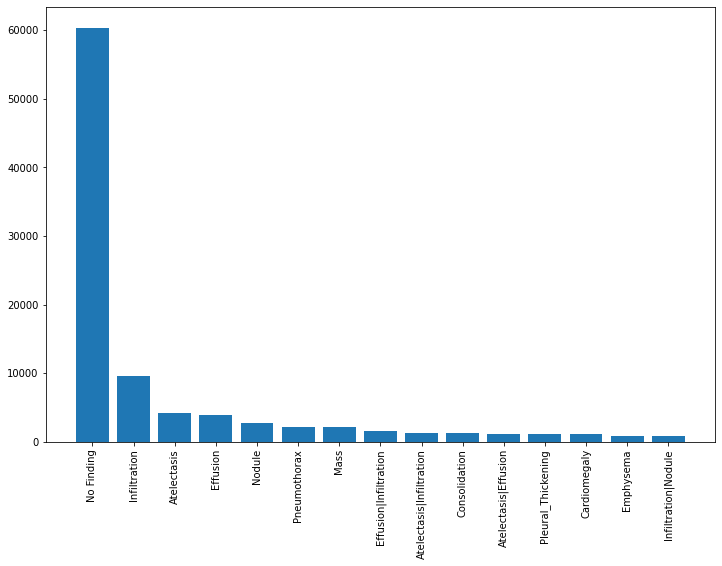

In [0]:
#For graph reprasentation we are converting to pandas df.
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
pdf = df.toPandas()
label_counts = pdf['labels'].value_counts()[:15]
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

We are perfoming one hot encoding as a part of data transformation. The features which are diseases in this case, are extracted from labels column and seperated to form another columns own its own. 0 and 1 are used to represent if the patient has disease or not.

In [0]:
#similarly we can do this on spark dataframe by using udf function
all_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

for c_label in all_labels: #loop the values
    if len(c_label)>1: # leave out empty labels
        oneHotEncoding = udf(lambda row: 1.0 if c_label in row else 0.0, DoubleType())  #udf to perform one Hot Encoding
        df = df.withColumn(c_label, oneHotEncoding('labels')) #adding new columns using withColumn fn
        df.count()
display(df.limit(7))

imageIndex,labels,followUp,id,age,gender,viewPosition,width,height,imagePixelSpacingX,imagePixelSpacingY,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
pdf['labels'] = pdf['labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*pdf['labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        pdf[c_label] = pdf['labels'].map(lambda finding: 1.0 if c_label in finding else 0)
pdf.sample(2)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Out[10]:

,imageIndex,labels,followUp,id,age,gender,viewPosition,width,height,imagePixelSpacingX,imagePixelSpacingY,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
64496,00015915_012.png,Effusion,12,15915,65,F,PA,2854,2991,0.143,0.143,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39198,00010282_000.png,,0,10282,46,M,PA,2992,2991,0.143,0.143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [0]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if pdf[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(pdf[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]

##4.Data Visualisation

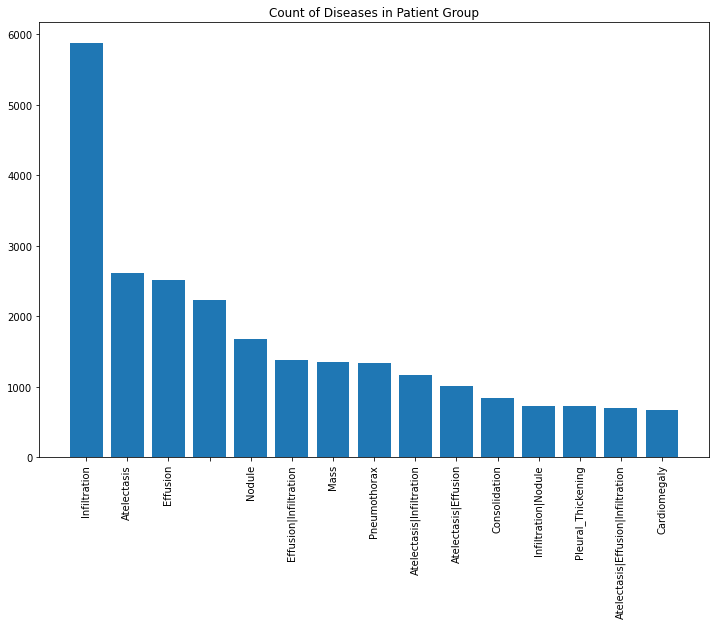

In [0]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = pdf['labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
pdf = pdf.sample(40000, weights=sample_weights)

label_counts = pdf['labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)

ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_title('Count of Diseases in Patient Group')
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

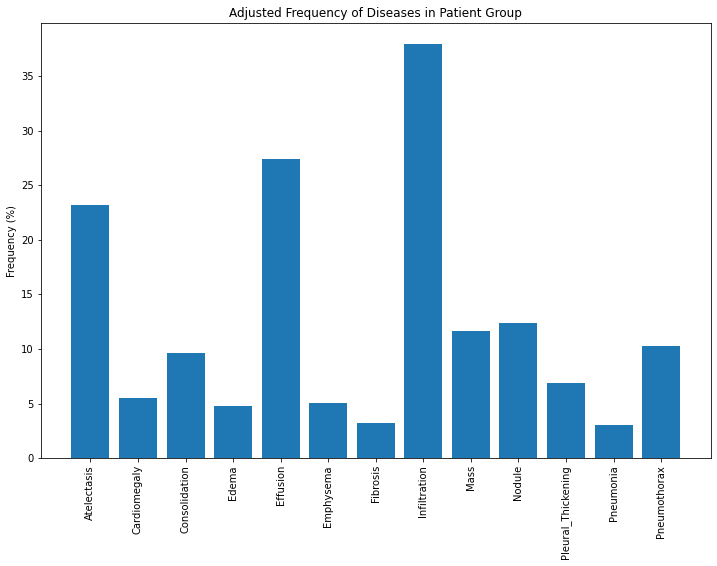

In [0]:
#normalization is performed on  label count to get a clearer graph
label_counts = 100*np.mean(pdf[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

By inferring the above graph we can conclude that Infiltration is the most common disease which has the highest frequency of diseases in patient group

So our hypothesis, Infiltration is the most common disease among the 14 diseases is true.

##GOAL 2
##1. Data Aggregation 

The data loading part is same as goal 1 and we can use the dataframe from goal 1 to perform descriptive analysis.

##2. Data Transformation

In [0]:
from pyspark.sql.types import *
mySchema = StructType([ StructField("imageIndex", StringType(), True)\
                       ,StructField("labels", StringType(), True)\
                       ,StructField("followUp", IntegerType(), True)\
                       ,StructField("id", IntegerType(), True)\
                       ,StructField("age", IntegerType(), True)\
                       ,StructField("gender", StringType(), True)\
                       ,StructField("viewPosition", StringType(), True)\
                       ,StructField("width", DoubleType(), True)\
                       ,StructField("height", DoubleType(), True)\
                       ,StructField("imagePixelSpacingX", DoubleType(), True)\
                       ,StructField("imagePixelSpacingY", DoubleType(), True)\
                       ,StructField("Atelectasis", IntegerType(), True)\
                       ,StructField("Cardiomegaly", IntegerType(), True)\
                       ,StructField("Consolidation", IntegerType(), True)\
                       ,StructField("Edema", IntegerType(), True)\
                       ,StructField("Effusion", IntegerType(), True)\
                       ,StructField("Emphysema", IntegerType(), True)\
                       ,StructField("Fibrosis", IntegerType(), True)\
                       ,StructField("Hernia", IntegerType(), True)\
                       ,StructField("Infiltration", IntegerType(), True)\
                       ,StructField("Mass", IntegerType(), True)\
                       ,StructField("Nodule", IntegerType(), True)\
                       ,StructField("Pleural_Thickening", IntegerType(), True)\
                       ,StructField("Pneumonia", IntegerType(), True)\
                       ,StructField("Pneumothorax", IntegerType(), True)])

In [0]:
#we can create spark dataframe from pandas dataframe using createDataFrame which requires schema
sdf = spark.createDataFrame(pdf,schema=mySchema)

In [0]:
#Temporary view is created using createOrReplaceTempView, for performing sql operations. Table name is given as params. 
sdf.createOrReplaceTempView("patients_details")

##2. Descriptive Analytics

In [0]:
# we can create new spark df by using sqlContext.sql() method by giving sal query as params.
cardio_df = sqlContext.sql("select id, age from patients_details where Cardiomegaly = 1").distinct()
display(cardio_df)

id,age
7292,46
10314,67
5878,58
19373,39
5066,50
20968,56
28963,32
1911,63
30437,74
2889,7


In [0]:
from pyspark.sql.functions import udf

#udf function is used to sort out data in age range vise.
age_range = udf(lambda age: '1 < 20' if age < 20 else 
                   '20-30' if (age >= 20 and age < 30) else
                   '30-40' if (age >= 30 and age < 40) else
                   '40-50' if (age >= 40 and age < 50) else
                   '50-60' if (age >= 50 and age < 60) else
                   '60-70' if (age >= 60 and age < 70) else
                   '70-80' if (age >= 70 and age < 80) else
                    '80+'  if (age >= 80) else '')

cardio_df = cardio_df.withColumn('age_range', age_range(cardio_df.age))


In [0]:

#we can use display method provided by pyspark to visualize data 
#count according to age range is calculated using groupby followed with count function 
display(cardio_df.groupBy(['age_range']).count().sort('age_range'))


age_range,count
1 < 20,74
20-30,155
30-40,248
40-50,260
50-60,347
60-70,287
70-80,128
80+,35


Out[20]:

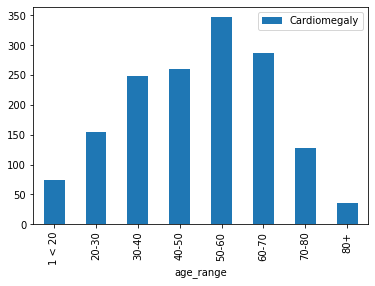

<AxesSubplot:xlabel='age_range'>

In [0]:
#Alternative way to plot graph is to use matlib lib but the dataframe has to be converted to pandas. toPandas() method can be used to perfrom convertion. 
cardio_pdf = cardio_df.groupBy(['age_range']).count().sort('age_range').toPandas()

cardio_pdf.plot(kind='bar', x='age_range', y='count', label='Cardiomegaly')

In [0]:
#Similarly we can combine two or more dataframes in a single graph.
infiltration_df = sqlContext.sql("select id, age from patients_details where Infiltration = 1").distinct()
pneumonia_df = sqlContext.sql("select id, age from patients_details where Pneumonia = 1").distinct()

##4.Data Visualisation

Out[22]:

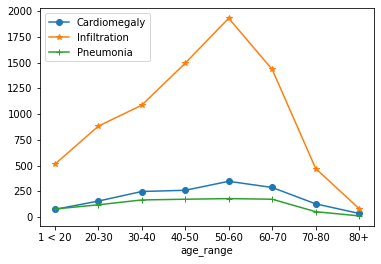

<AxesSubplot:xlabel='age_range'>

In [0]:
infiltration_df = infiltration_df.withColumn('age_range', age_range(infiltration_df.age))
pneumonia_df = pneumonia_df.withColumn('age_range', age_range(pneumonia_df.age))

infiltration_pdf = infiltration_df.groupBy(['age_range']).count().sort('age_range').toPandas()
pneumonia_pdf = pneumonia_df.groupBy(['age_range']).count().sort('age_range').toPandas()

# we will be able to plot multiple items against it
ax = plt.gca()

cardio_pdf.plot(kind='line', x='age_range', y='count', label='Cardiomegaly', ax=ax , marker='o' )
infiltration_pdf.plot(kind='line', x='age_range', y='count', label='Infiltration', ax=ax , marker='*')
pneumonia_pdf.plot(kind='line', x='age_range', y='count', label='Pneumonia', ax=ax , marker='+' )

The graph incicates the comparison between three different diseases and thier occurance in relavance to their age group. We can clearly see that at in age range of 50 to 60 the number of patients are more. The line of each observation have a sligt increase in slope till age range 50-60 but later gradual decrease can be noticed.